In [1]:
from typing import Any
import random
import os

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from validation_model import ValidationModel
from settings import *
from avapix.avapix_loss import AvapixLoss
from avapix.avapix_model import AvapixModel
import avapix.avapix_utils as utils

In [2]:
DEVICE = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print (f'Using device: {DEVICE}')

Using device: cuda


In [21]:
class EmbeddedFacesDataset(Dataset):
    def __init__(self, num_samples) -> None:
        super().__init__()

        self.transform = ToTensor()

        self.num_samples = num_samples
        self.random_lengths = list(range(128))

    def __getitem__(self, index) -> Any:
        curr_rand_len = random.choice(self.random_lengths)

        curr_image_tensor = np.random.randint(0, 256, (8, 8, 3))
        curr_image_tensor = torch.tensor(curr_image_tensor, device=DEVICE, dtype=torch.float)
        output_img = utils.generate_input_v1(curr_image_tensor,
                                             DEFAULT_RANDOM_SEED,
                                             curr_rand_len)
        output_img = output_img.reshape((8, 8, 3)).permute((2, 0, 1))

        return output_img / 255

    def __len__(self):
        return self.num_samples


In [22]:
import importlib
import avapix.avapix_model
import avapix.avapix_loss
import avapix.avapix_utils
importlib.reload(avapix.avapix_model)
importlib.reload(avapix.avapix_loss)
importlib.reload(avapix.avapix_utils)
from avapix.avapix_model import AvapixModel
from avapix.avapix_loss import AvapixLoss
import avapix.avapix_utils as utils

In [23]:
LEARNING_RATE = 0.00005
BATCH_SIZE = 32
NUM_EPOCHS = 5

image_list = os.listdir(VALID_FACE_DIR)
image_list = [os.path.join(VALID_FACE_DIR, img_file) for img_file in image_list]

dataset = EmbeddedFacesDataset(50_000)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

model = AvapixModel()

criterion = AvapixLoss(0.000001)

loss_model = ValidationModel()
loss_model.load_state_dict(torch.load('./assets/validation_model.pth'))

optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=1e-4)

In [59]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001,
                             weight_decay=1e-4)

In [60]:
losses = []

_ = 0
for epoch in range(10):
    model.train()
    total_loss = 0.0

    for batch_imgs in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_imgs)

        possibility_pred = loss_model(outputs)
        
        loss = criterion(possibility_pred)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    # for i, tensor_img in enumerate(outputs):
    #     img = img_tensor_to_numpy(tensor_img) * 255
    #     img = img.astype(np.uint8)
    #     Image.fromarray(img).save(f'./train_outputs/{_}_{i}.png')
    # _ += 1

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)

    print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}")
    # if epoch % 10 == 9:
    #     print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}", end='\t')
    #     if (epoch + 1) % 20 == 0:
    #         print()

print("Training complete.")

Epoch 001/5 - Loss: 2.4625
Epoch 002/5 - Loss: 2.4618
Epoch 003/5 - Loss: 2.4618
Epoch 004/5 - Loss: 2.4618
Epoch 005/5 - Loss: 2.4618
Epoch 006/5 - Loss: 2.4617
Epoch 007/5 - Loss: 2.4617
Epoch 008/5 - Loss: 2.4617
Epoch 009/5 - Loss: 2.4617
Epoch 010/5 - Loss: 2.4617
Training complete.


## Test Area
---

In [344]:
import importlib
import avapix.avapix_model
import avapix.avapix_loss
import avapix.avapix_utils
import validation_model
importlib.reload(avapix.avapix_model)
importlib.reload(avapix.avapix_loss)
importlib.reload(avapix.avapix_utils)
importlib.reload(validation_model)
from avapix.avapix_model import AvapixModel
from avapix.avapix_loss import AvapixLoss
import avapix.avapix_utils as utils
from validation_model import ValidationModel

LEARNING_RATE = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 100
GEN_PER_IMAGE = 10

image_list = os.listdir(VALID_FACE_DIR)
image_list = [os.path.join(VALID_FACE_DIR, img_file) for img_file in image_list]

dataset = EmbeddedFacesDataset(100000)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

model = AvapixModel()

criterion = AvapixLoss()

loss_model = ValidationModel()
loss_model.load_state_dict(torch.load('./assets/validation_model.pth'))

optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=1e-4)

for batch_imgs in dataloader:
    outputs = model(batch_imgs)
    break

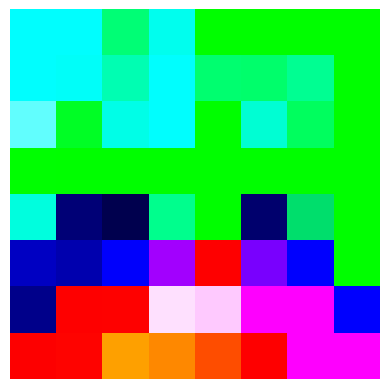

In [61]:
utils.show_model_output_image(outputs[15])

---

In [62]:
_ = utils.embed_raw_img_v1('bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh', 42).to(DEVICE) / 255
_ = _.reshape((3, 8, 8))
_ = _.unsqueeze(0)

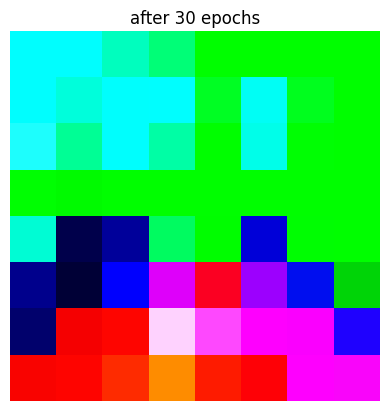

In [63]:
i_ = model(_)
utils.show_model_output_image(i_, 'after 30 epochs')